# Add loops to the designed bound states

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_shifties
running on node: dig58


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Add loops between chA and chB

In [3]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "01_loop_bound_states"
design_list_file = os.path.join(
    os.getcwd(), "projects/crispy_shifties/00_design_bound_states/designed_states.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
        "indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.looping.loop_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="4G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-1541 /mnt/projects/crispy_shifty/projects/crispy_shifties/01_loop_bound_states/run.sh


### Collect scorefiles of designed bound states and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "01_loop_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/1186 [00:00<?, ?it/s]

### Setup for plotting

In [5]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [6]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))
scores_df.columns

1186


Index(['bb_clash', 'bb_clash_delta', 'best_average_DAN_plddts',
       'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input',
       'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB',
       'docked_helix', 'dssp', 'exposed_hydrophobics_parent',
       'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'loop_dist',
       'loop_sc', 'looped_length', 'mismatch_probability_parent',
       'new_loop_str', 'packstat_parent', 'parent', 'parent_length', 'path_in',
       'pdb', 'pivot_helix', 'pre_break_helix', 'sap_parent', 'sc_AcB',
       'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type',
       'score', 'score_per_res', 'score_per_res_parent', 'shift', 'ss_sc',
       'state', 'time', 'topo', 'total_length', 'total_score',
       'trimmed_length'],
      dtype='object')

### Convert some dtypes

In [7]:
scores_df["bb_clash_delta"] = scores_df.bb_clash.astype(float)
scores_df["looped_length"] = scores_df.looped_length.astype(int)
scores_df["trimmed_length"] = scores_df.trimmed_length.astype(int)
scores_df["loop_length_delta"] = (
    scores_df["looped_length"] - scores_df["trimmed_length"]
)

### Check for the relationship between `bb_clash_delta` and `looped_length`

3it [00:00, 39.58it/s]


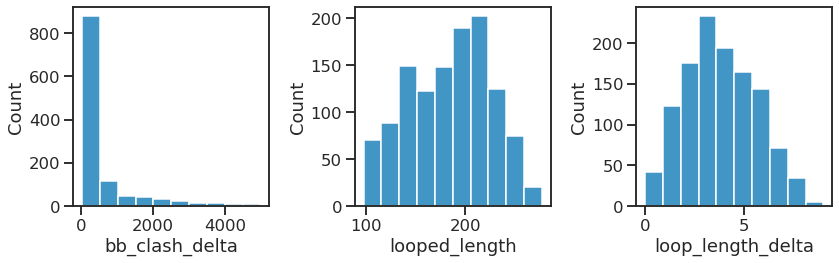

In [8]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

cols = ["bb_clash_delta", "looped_length", "loop_length_delta"]

the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=10,
)

plt.savefig(os.path.join(output_path, "bb_clash_vs_length.png"))

<Figure size 864x864 with 0 Axes>

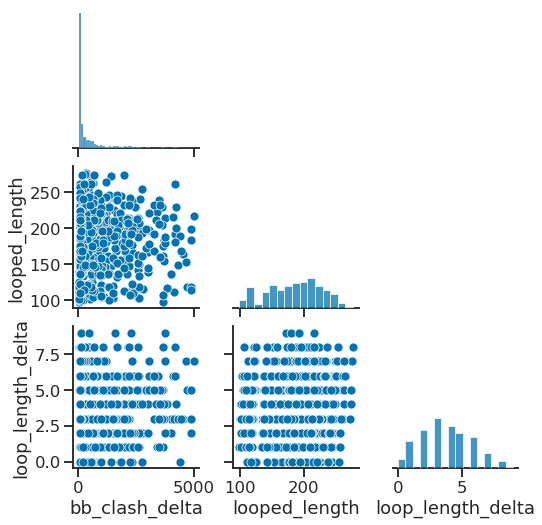

In [9]:
the_fig = pairplot_df(
    df=scores_df,
    cols=cols,
)

plt.savefig(os.path.join(output_path, "bb_clash_vs_length_paired.png"))

### Filter the looped states leniently
We want to discard the obviously bad stuff here

In [15]:
final_df = scores_df.query("loop_length_delta < 7 and bb_clash_delta < 1000")
print(len(final_df))

898


### Save a list of outputs

In [17]:
simulation_name = "01_loop_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "looped_states.list"), "w") as f:
    for path in tqdm(final_df.index):
        print(path, file=f)

  0%|          | 0/898 [00:00<?, ?it/s]

### Prototyping blocks

test `loop_bound_state`

In [ ]:
%%time 
import pyrosetta

pyrosetta.init(
    "-corrections::beta_nov16 -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5"
)


sys.path.insert(0, "/projects/crispy_shifty/")
from crispy_shifty.protocols.looping import loop_bound_state

t = loop_bound_state(
        None,
        **{
            'pdb_path': '/mnt/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/decoys/0000/00_design_bound_states_781df9c2878d4792982780ca383ea9ed.pdb.bz2',
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
import pyrosetta.distributed.viewer as viewer

ppose = pyrosetta.distributed.io.pose_from_file("test.pdb")
view = viewer.init(ppose, window_size=(1600, 1200))
view.add(viewer.setStyle())
view.add(viewer.setStyle(colorscheme="whiteCarbon", radius=0.10))
view.add(viewer.setHydrogenBonds())
view.add(viewer.setHydrogens(polar_only=True))
view.add(viewer.setDisulfides(radius=0.25))
view()